# Unsupervised Anomaly Detection using Vector Embedding of Text Security Logs
This is a continuation of the prior research, leveraging Isolation Forest to execute unsupervised training of an anomaly detection model. As we'll see, the results are better than simply clustering the data using it's vector embedding, but it's still not perfect.  That said, the results are around twice as accurate as the clustering exercise.

In [51]:
### Uncomment and run the line below if this is the first time executing this notebook. Package installs in requirements.txt.
#! python -m venv venv
#! powershell venv\Scripts\Activate.ps1
###! pip install -r .\requirements.txt --force

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA


In [12]:

# We'll use the mixed proxy logs to see if we can get them clustered into 950 benign + 50 malicious
df = pd.read_csv('proxy_logs_mixed.csv')
df = df.drop(['IP Address', 'Timestamp'], axis=1)  # We don't need IP nor timestamp for this task
df.sample(3)


,ID,Log Entry
142,143,"GET http://cloudstorage.com/files HTTP/1.1"" 20..."
703,704,"GET http://cloudstorage.com/files HTTP/1.1"" 20..."
376,377,"GET http://cloudstorage.com/login HTTP/1.1"" 20..."


In [16]:
# Load the embedding model so we can use it to easily populate the dataframe
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
#model = SentenceTransformer("multi-qa-mpnet-base-cos-v1")  # Different results, longer but not better
# Use like this: embeddings = model.encode(whatever_text)

# Use a lambda function to encode the text in each row and apply it to a new column
df['embedding'] = df['Log Entry'].apply(lambda text:model.encode(text))
df.sample(3)

c:\Users\Dave Sisk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
c:\Users\Dave Sisk\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Dave Sisk\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you e

,ID,Log Entry,embedding
236,237,"GET http://intranet.company.com/home HTTP/1.1""...","[0.004372136, -0.029089237, -0.0073304796, -0...."
879,880,GET http://update.software.com/version.xml HTT...,"[-0.019630136, 0.0034926734, 0.026339676, -0.0..."
248,249,GET http://update.software.com/version.xml HTT...,"[-0.020643428, 0.006049854, 0.025493953, -0.05..."


In [33]:
# Define a model object with the Isolation Forest algorithm
#model=IsolationForest(n_estimators=100,max_samples='auto',contamination=0.05,random_state=96)
model=IsolationForest(n_estimators=100,max_samples='auto',contamination='auto',random_state=96)

# Convert the embedding column to a numpy array for input to IsolationForest...it's a little nit-picky here
X = np.vstack(df['embedding'].values)

# Fit the data to the model
model.fit(X)

# Display parameter values that were used
model.get_params()

{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': 96,
 'verbose': 0,
 'warm_start': False}

In [69]:
# Add a column to the DF for scores from the model's decision_function
df['scores'] = model.decision_function(X)

# Add a column to the DF for the anomaly flag from the model's predict function...-1 indicates anomaly
df['anomaly_score'] = model.predict(X)


In [71]:
# Display the data with the columns added
df.sample(3)

,ID,Log Entry,embedding,scores,anomaly_score
933,934,"GET http://intranet.company.com/home HTTP/1.1""...","[0.037428904, -0.024605729, -0.036516894, -0.0...",0.008578,1
743,744,"GET http://www.example.com/style.css HTTP/1.1""...","[-0.030201474, 0.061550565, 0.015971683, -0.00...",0.016223,1
490,491,GET http://update.software.com/version.xml HTT...,"[-0.018490966, 0.0039772675, 0.027044179, -0.0...",0.039729,1


In [105]:
# Display just the anomalies
df[df['anomaly_score']==-1].sample(3)

,ID,Log Entry,embedding,scores,anomaly_score
306,307,GET http://cloudstorage.com/authenticate HTTP/...,"[-0.03127418, 0.043131024, -0.037412006, -0.03...",-0.007839,-1
513,514,GET http://intranet.company.com/docs/document....,"[-0.0113884965, -0.015165894, -0.06410778, -0....",-0.013948,-1
24,25,"GET http://cloudstorage.com/files HTTP/1.1"" 20...","[-0.017498257, 0.03056147, 0.016485153, -0.007...",-0.016017,-1


In [106]:
# anomaly_score = -1 are the outliers
# This is much better than the 711/289 from clustering, but still not the actual 950/50 that we know 
# the test data to be
df['anomaly_score'].value_counts()

anomaly_score
 1    824
-1    176
Name: count, dtype: int64

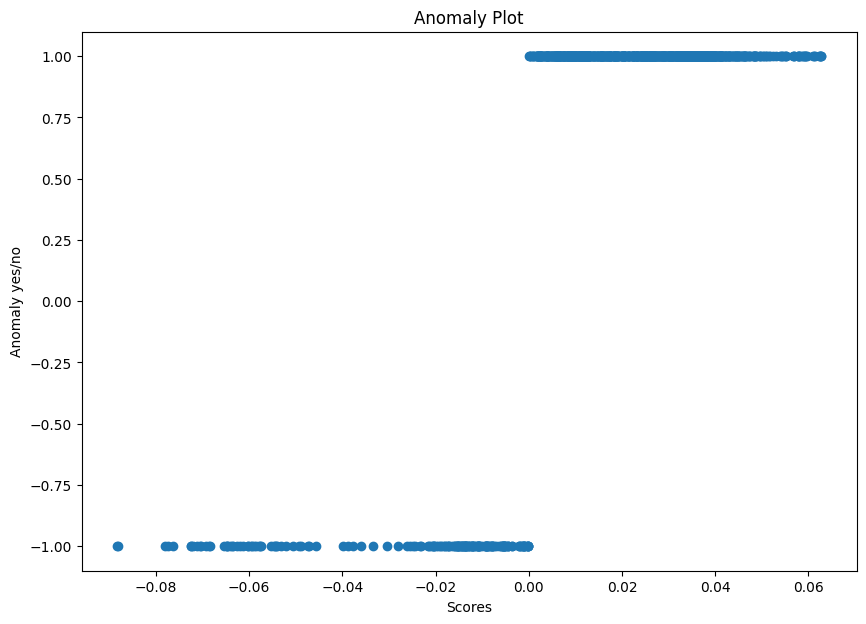

In [107]:
# If we just do a scatter plot of the anomaly_score results, it's very clear...but doesn't really tell us much.
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df.scores, df.anomaly_score)
plt.title('Anomaly Plot')
plt.xlabel('Scores')
plt.ylabel('Anomaly yes/no')
plt.show()

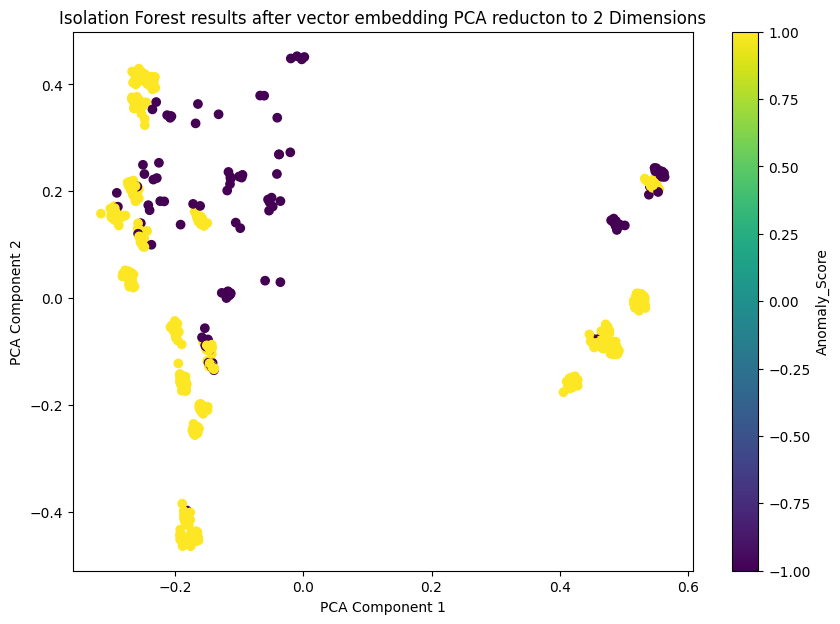

In [67]:
# Plot the results after applying PCA to the vector embeddings...color indicates the anomaly score.
# This is a bit like plotting two things to try to understand how/why they align/not...the dark colors are
# the samples that were flagged as anomalies.

# Reduce the embeddings to 2 dimensions using PCA
pca = PCA(n_components=2)
embeddings = df['embedding'].tolist()
reduced_embeddings = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df['anomaly_score'], cmap='viridis', marker='o')
plt.title('Isolation Forest results after vector embedding PCA reducton to 2 Dimensions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Anomaly_Score')
plt.show()